# CS5814: Assignment 2

## Problem 2

This problem involves implementing a Convolutional Neural Network to classify images within the MNIST and CIFAR-100 datasets. Information on these datasets are available here: https://en.wikipedia.org/wiki/MNIST_database and https://www.cs.toronto.edu/~kriz/cifar.html


### Imports and config

In [1]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)  # Supressing Jupyter Notebook torchvision installation error 

import torch
import torch.utils.data as data_utils
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms, datasets

import os
import random
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn import metrics
import seaborn as sns
from tqdm import tqdm

os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [2]:
# Setting random seeds

RANDOM_SEED = 3819969

torch.manual_seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

In [3]:
# Checking GPU configuration
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## Data preprocessing

Creating DataLoaders for the MNIST and CIFAR100 datasets, all data is used within the default train/test sets.

A minibatch size of 32 is used for both datasets.

In [4]:
def download_data_MNIST():
    
    # Ratio of data to keep (100%)
    keep_ratio = 1
    
    # Train data
    train = datasets.MNIST("", train=True, download=True,
                           transform=transforms.Compose(
                               [transforms.ToTensor()]))
    train = data_utils.Subset(train, torch.randperm(len(train))[:int(keep_ratio * len(train))])

    # Testing data
    test = datasets.MNIST("", train=False, download=True,
                          transform=transforms.Compose(
                              [transforms.ToTensor()]))
    test = data_utils.Subset(test, torch.randperm(len(test))[:int(keep_ratio * len(test))])

    # Generating DataLoader
    trainset = torch.utils.data.DataLoader(train, batch_size=32, shuffle=True)
    testset = torch.utils.data.DataLoader(test, batch_size=32, shuffle=True)

    return trainset, testset

trainset_MNIST, testset_MNIST = download_data_MNIST()

In [5]:
def download_data_CIFAR100():
    
    # Ratio of data to keep (100%)
    keep_ratio = 1
    
    # Train data
    train = datasets.CIFAR100("", train=True, download=True,
                           transform=transforms.Compose(
                               [transforms.ToTensor()]))
    train = data_utils.Subset(train, torch.randperm(len(train))[:int(keep_ratio * len(train))])

    # Testing data
    test = datasets.CIFAR100("", train=False, download=True,
                          transform=transforms.Compose(
                              [transforms.ToTensor()]))
    test = data_utils.Subset(test, torch.randperm(len(test))[:int(keep_ratio * len(test))])

    # Loading the datasets
    trainset = torch.utils.data.DataLoader(train, batch_size=32, shuffle=True)
    testset = torch.utils.data.DataLoader(test, batch_size=32, shuffle=True)

    return trainset, testset

trainset_CIFAR100, testset_CIFAR100 = download_data_CIFAR100()

Files already downloaded and verified
Files already downloaded and verified


## Network Definitions

### CNN

CNN definition using:

    Conv:                 [variable input size based on dataset channels, 16 output channels, 3x3 kernal, stride of 1]
    ReLU
    MaxPool:              [2x2]
    Conv:                 [16 input channels, 32 output channels, 5x5 kernal, stride of 1]
    RelU
    MaxPool:              [2x2]
    Fully connected:      [variable input size based on dataset channels, 1024 output channels]
    Fully Connected:      [1024 input channels, number of classes output (10 or 100)]
    Softmax

In [6]:
class CNN(nn.Module):
    def __init__(self, input_channels = 1, fc_width=512, classes=10):
        
        super(CNN, self).__init__()
        
        self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=input_channels,              
                out_channels=16,            
                kernel_size=3,              
                stride=1,                   
                padding=0,                  
        ),                              
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),    
        )
        self.conv2 = nn.Sequential(         
            nn.Conv2d(
                in_channels=16,              
                out_channels=32,            
                kernel_size=5,              
                stride=1,                   
                padding=0,                  
            ),                              
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),    
        )
        
        
        # Note that fc_width is a function of the input image size
        # TODO - this can be infered vs hard coded (currently 512 or 800)
        self.fc_1 = nn.Linear(fc_width, 1024).to(device)
        self.fc_2 = nn.Linear(1024, classes).to(device)
        
        self.softmax = nn.Softmax()
        
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.conv2(x)
        
        # flatten the output of conv2 to (batch_size, X)
        x = torch.flatten(x, start_dim=1, end_dim=- 1)   
        x = self.fc_1(x)
        x = self.fc_2(x)
                
        output = self.softmax(x)
        
        return output

## Training

In [7]:
def training_base(model, optimizer, criterion, epochs, testset, trainset, classes=100, validate_step=100):
    # Main training loop for a given model, optimizer and evaluation criterion
    
    loss = 0  
    weight_updates = 0  # Number of weight updates conducted

    # Arrays for tracking training metrics
    train_loss_array = []
    metric_list = []
    train_accuracy_array = []
    val_loss_array = []
    
    # Start training
    for epoch in range(epochs):
        
        train_prediction_list = []
        train_label_list = []
        
        mini_batch_id = 0
        correct = 0
        total = 0
        
        for X, y in tqdm(trainset):
            
            # Moving data to GPU
            X, y = X.to(device), y.to(device)
            model.zero_grad()
            
            # Forward step
            output = model.forward(X)
            train_prediction_list.append(torch.argmax(output, dim=1).cpu().numpy())
            train_label_list.append(y.cpu().numpy())
            
            # TODO - tidy up this messy expression
            # Calculate accuracy
            batch_accuracy = np.count_nonzero(torch.argmax(output, dim=1).cpu().numpy()==y.cpu().numpy())/len(y.cpu().numpy())
            train_accuracy_array.append(batch_accuracy)
            
            # Backward step
            loss = criterion(output, y)           
            loss.backward()
            optimizer.step()
            
            # Updaing loss arrays
            train_loss_array.append(loss.item())

            # Validation
            if weight_updates % validate_step == 0 or weight_updates==0:
                
                val_loss_local_list = []
                prediction_list = []
                label_list  = []
            
                model.eval()
                for X, y in testset:
                    
                    # Move testset data to GPU
                    X, y = X.to(device), y.to(device)

                    # Evaluate model
                    val_output = model(X)
                    val_loss = criterion(val_output, y)
                    val_loss_local_list.append(val_loss.item())
                    
                    # Tracking results
                    prediction_list.append(torch.argmax(val_output, dim=1).cpu().numpy())
                    label_list.append(y.cpu().numpy())
                    
                val_loss_array.append(np.average(val_loss_local_list))
                    
                # Combining labels and predictions from batches of testset
                label_out = np.concatenate(label_list).ravel()
                pred_out = np.concatenate(prediction_list).ravel()
                
                # Calculating evaluation metrics
                target_names_int = [i for i in range(classes)]
                
                f1 = f1_score(label_out, pred_out, average=None, labels=target_names_int)
                precision = metrics.precision_score(label_out, pred_out, average=None, labels=target_names_int)
                recall = metrics.recall_score(label_out, pred_out, average=None, labels=target_names_int)
                accuracy_total = metrics.accuracy_score(label_out, pred_out)
                cm = confusion_matrix(label_out, pred_out, labels=target_names_int)
                accuracy_class = cm.diagonal()/cm.sum(axis=1)

                # Appending evaluation results from validation set
                metric_list.append([precision, recall, f1, accuracy_class])
                
                
            model.train()

            mini_batch_id += 1
            weight_updates+= 1
            
        # Collating training outputs
        train_label_out = np.concatenate(train_label_list).ravel()
        train_pred_out = np.concatenate(train_prediction_list).ravel()
        train_accuracy_total = metrics.accuracy_score(train_label_out, train_pred_out)
        
        # Printing results per epoch
        print("Epoch: {}, Train loss: {:.4f},Val los: {:.4f}, Train acc: {:.4f}, ".format(epoch,loss.item(),
                                                                                        val_loss_array[-1],
                                                                                         train_accuracy_total))
            
    return(model, metric_list, train_loss_array, train_accuracy_array, val_loss_array)

## MNIST Dataset
### Training

In [9]:
# Number of classes within MNIST (TODO - infer)
classes=10

# Loading model
model = CNN(input_channels=1,
           fc_width=512,
           classes=classes).to(device)

# Setting hyperparams
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
epochs = 5

# Training
model, MNIST_metric_list, train_loss_array, train_accuracy_array, val_loss_array = training_base(model,
                                    optimizer,
                                    criterion,
                                    epochs,
                                    testset=testset_MNIST,
                                    trainset=trainset_MNIST,
                                    classes=classes)

100%|██████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:58<00:00, 31.80it/s]


Epoch: 0, Train loss: 1.4612,Val los: 1.4849, Train acc: 0.9438, 


100%|██████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:04<00:00, 29.01it/s]


Epoch: 1, Train loss: 1.4772,Val los: 1.4884, Train acc: 0.9735, 


100%|██████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:10<00:00, 26.47it/s]


Epoch: 2, Train loss: 1.4612,Val los: 1.4808, Train acc: 0.9747, 


100%|██████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:01<00:00, 30.27it/s]


Epoch: 3, Train loss: 1.5117,Val los: 1.4797, Train acc: 0.9777, 


100%|██████████████████████████████████████████████████████████████████████████████| 1875/1875 [01:06<00:00, 28.01it/s]

Epoch: 4, Train loss: 1.4924,Val los: 1.4926, Train acc: 0.9795, 


## Results

## MNIST

In [12]:
def movingaverage(interval, window_size=10):
    """Helper function to calulate moving averages based on window size"""
    
    window= np.ones(int(window_size))/float(window_size)
    return np.convolve(interval, window, 'same')

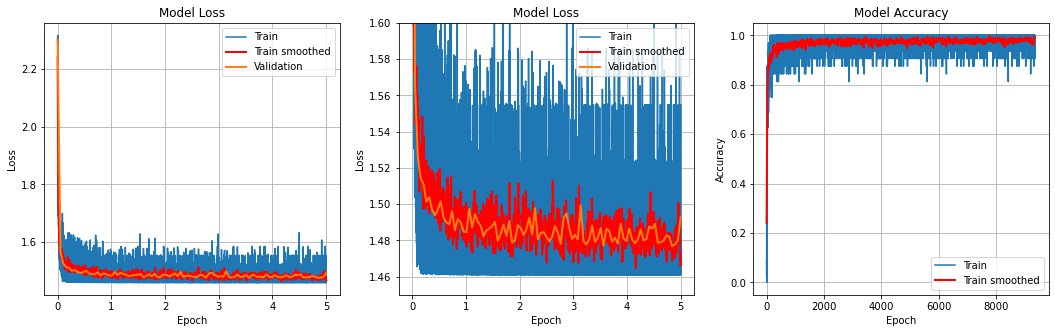

In [34]:
fig, axs = plt.subplots(1, 3)
fig.set_size_inches(18, 5)

axs[0].plot(np.linspace(0, 5, len(train_loss_array)), train_loss_array, label="Train")


smoothed_train_loss = movingaverage(train_loss_array,20)[10:-10]
axs[0].plot(np.linspace(0, 5, len(smoothed_train_loss)), smoothed_train_loss,
                        label="Train smoothed", linewidth=2, color="red")
axs[0].plot(np.linspace(0, 5, len(val_loss_array)), val_loss_array,label = "Validation", linewidth=2) 


axs[0].set_title("Model Loss")
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend(loc="upper right")
axs[0].grid()

axs[2].plot(train_accuracy_array, label="Train")
axs[2].plot(movingaverage(train_accuracy_array,20)[10:-10],label="Train smoothed",
            linewidth=2, color="red",)
axs[2].set_title("Model Accuracy")
axs[2].set_xlabel('Epoch')
axs[2].set_ylabel('Accuracy')
axs[2].legend()
axs[2].grid()


axs[1].plot(np.linspace(0, 5, len(train_loss_array)), train_loss_array, label="Train")


smoothed_train_loss = movingaverage(train_loss_array,20)[10:-10]
axs[1].plot(np.linspace(0, 5, len(smoothed_train_loss)), smoothed_train_loss,
                        label="Train smoothed", linewidth=2, color="red")
axs[1].plot(np.linspace(0, 5, len(val_loss_array)), val_loss_array,label = "Validation", linewidth=2)
axs[1].set_ylim(1.45,1.6)
axs[1].set_title("Model Loss")
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')

axs[1].legend()
axs[1].grid()

plt.show()

In [37]:
MNIST_metric_list = np.array(MNIST_metric_list)
class_avg = MNIST_metric_list.sum(axis=2)/classes

print("Final test set performance metrics:\n(averaged across {} classes)\n------------------------".format(classes))
metric_labels = ['precision', 'recall', 'f1', 'accuracy']
for i, label in enumerate(metric_labels):
    print("{0}: {1:.4f}".format(label, class_avg[-1,i]))

Final test set performance metrics:
(averaged across 10 classes)
------------------------
precision: 0.9697
recall: 0.9683
f1: 0.9683
accuracy: 0.9683


## Visulizing 10 samples (from test set) and displaying prediction

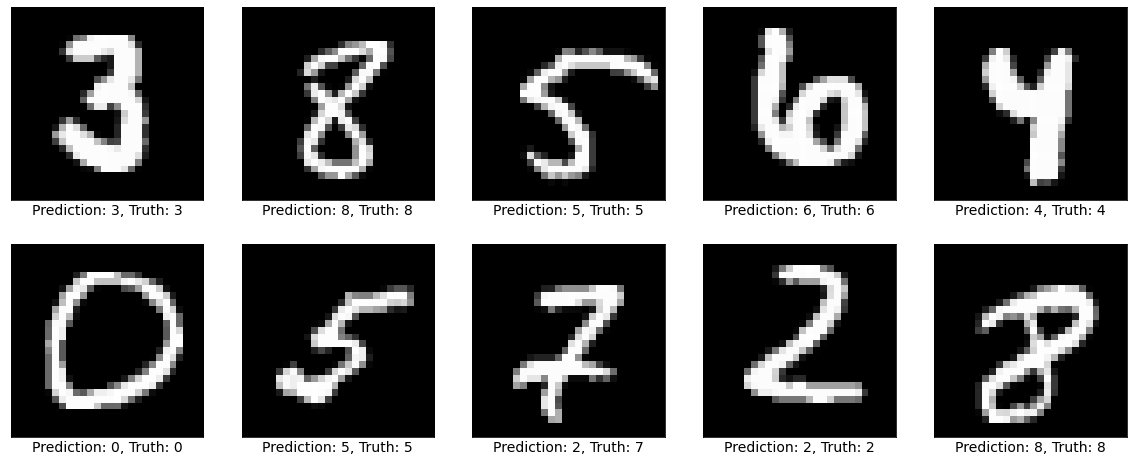

In [42]:
# Getting one mini batch from testset (32 images)
# 10 images are then selected from this minibatch
for X, y in testset_MNIST:
    
    X, y = X.to(device), y.to(device)
    
    # Configuring output plots
    fig, axs = plt.subplots(nrows=2, ncols=5)
    fig.set_size_inches(20, 8)
    
    # Iterating through axs
    for i, ax in enumerate(axs.reshape(-1)):        
        
        # Getting image and moving to cpu 
        ax.imshow(X[i][0].cpu(), cmap='gray')
        
        # Getting prediction
        output = model(X[i].reshape(-1, 1, 28, 28))
        prediction = torch.argmax(output, dim=1).cpu().numpy()[0]
        
        # Getting truth label
        turth = y[i].item()
        
        # Adding caption and clearing axis ticks
        ax.set_xlabel("Prediction: {}, Truth: {}".format(prediction, turth), fontsize=14)
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        ax.set_xticks([])
        ax.set_yticks([])
        
    fig.show()
    break  # Break such that only one minibatch is processed (as this provides enough images)

### Visualizing Feature Maps

In [75]:
# Helper function
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

Conv 1 Activation Maps


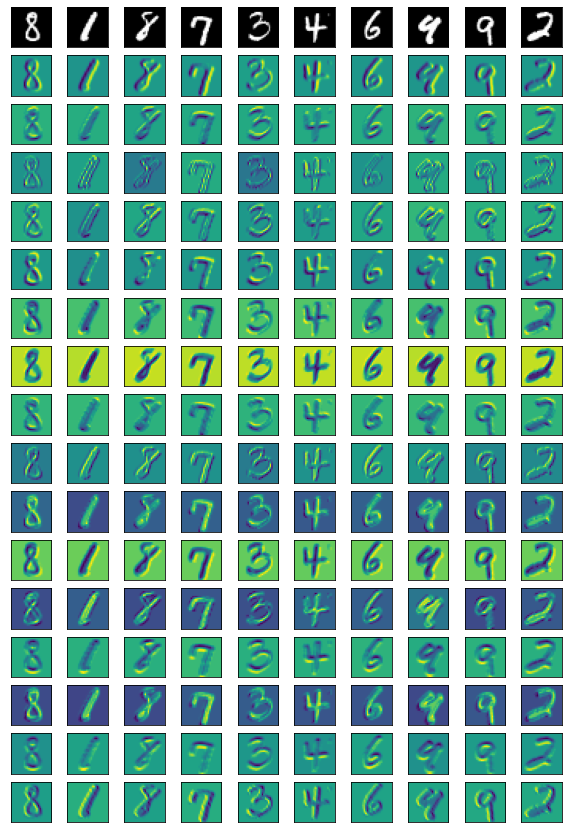

In [78]:
for X, y in testset_MNIST:
    X, y = X.to(device), y.to(device)
    
    fig, axarr = plt.subplots(nrows = 16+1, ncols=10, figsize=(7,7))
    fig.set_size_inches(10, 15)

    for i in range(10):        
        
        model.conv1[0].register_forward_hook(get_activation('conv1'))
        data=X[i].reshape(-1, 1, 28, 28)
        output_test = model(data)

        act = activation['conv1'].squeeze()

        for idx in range(1, act.size(0)+1):
            axarr[idx][i].imshow(act[idx-1].cpu())
            axarr[idx][i].set_yticklabels([])
            axarr[idx][i].set_xticklabels([])
            axarr[idx][i].set_xticks([])
            axarr[idx][i].set_yticks([])
        
        axarr[0][i].imshow(data[0][0].cpu(), cmap='gray')
        axarr[0][i].set_yticklabels([])
        axarr[0][i].set_xticklabels([])
        axarr[0][i].set_xticks([])
        axarr[0][i].set_yticks([])
    
    print("Conv 1 Activation Maps")
    plt.show()
    break

Conv 2 Activation Maps


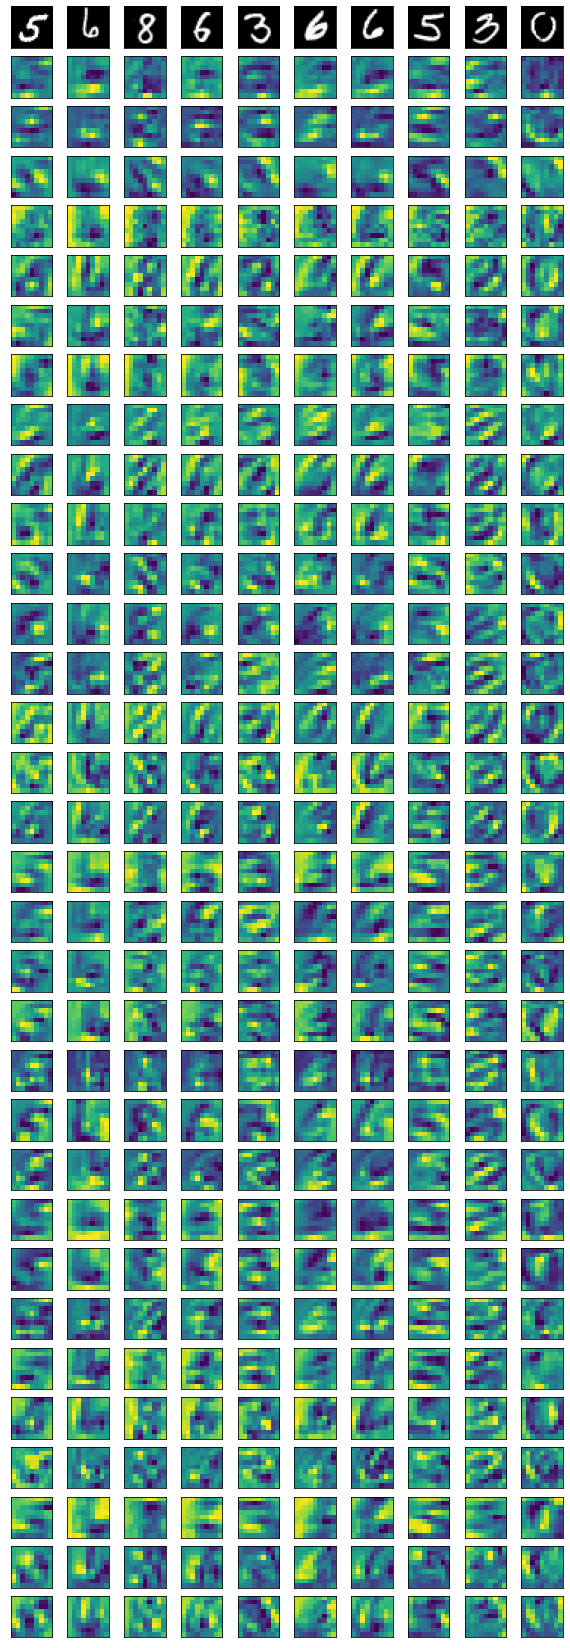

In [79]:
activation = {}

for X, y in testset_MNIST:
    X, y = X.to(device), y.to(device)
    
    fig, axarr = plt.subplots(nrows = 32+1, ncols=10, figsize=(7,7))
    fig.set_size_inches(10, 30)

    for i in range(10):        
        
        model.conv2[0].register_forward_hook(get_activation('conv2'))
        data=X[i].reshape(-1, 1, 28, 28)
        output_test = model(data)

        act = activation['conv2'].squeeze()

        for idx in range(1, act.size(0)+1):
            axarr[idx][i].imshow(act[idx-1].cpu())
            axarr[idx][i].set_yticklabels([])
            axarr[idx][i].set_xticklabels([])
            axarr[idx][i].set_xticks([])
            axarr[idx][i].set_yticks([])
        
        axarr[0][i].imshow(data[0][0].cpu(), cmap='gray')
        axarr[0][i].set_yticklabels([])
        axarr[0][i].set_xticklabels([])
        axarr[0][i].set_xticks([])
        axarr[0][i].set_yticks([])
    
    print("Conv 2 Activation Maps")
    plt.show()
    break

### Visualizing Filter Layers

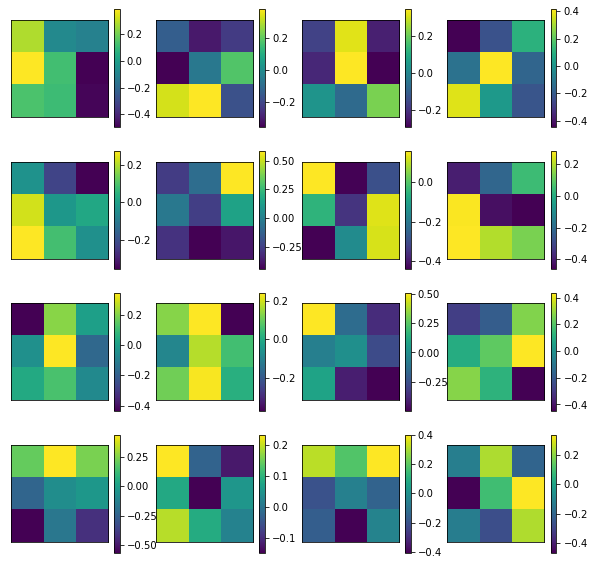

In [84]:
conv1_weights = model.conv1[0].weight.cpu().detach().numpy()

fig, axs = plt.subplots(nrows = 4, ncols=4, figsize=(7,7))
fig.set_size_inches(10, 10)

for filter_id, ax in enumerate(axs.reshape(-1)):

    plot = ax.imshow(conv1_weights[filter_id][0])
    fig.colorbar(plot, ax=ax)
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_xticks([])
    ax.set_yticks([])
    
plt.show()


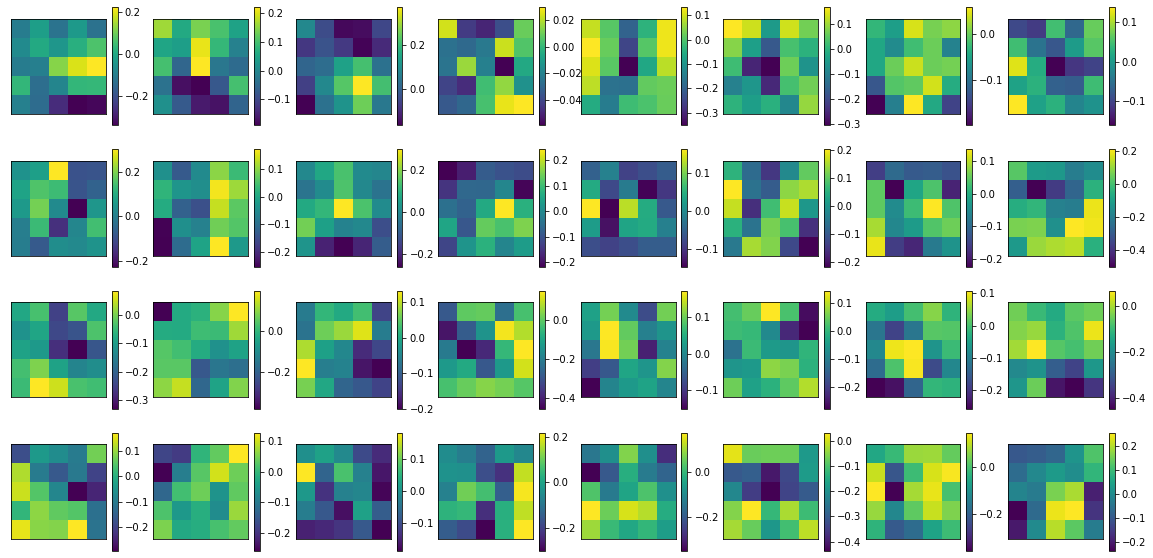

In [92]:
conv2_weights = model.conv2[0].weight.cpu().detach().numpy()

fig, axs = plt.subplots(nrows = 4, ncols=8, figsize=(7,7))
fig.set_size_inches(20, 10)

for filter_id, ax in enumerate(axs.reshape(-1)):

    plot = ax.imshow(conv2_weights[filter_id][0])
    fig.colorbar(plot, ax=ax)
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_xticks([])
    ax.set_yticks([])
    
plt.show()


## CIFAR100 Dataset
### Training

In [24]:
# Number of classes for CIFAR100
classes=100

# Loading model (with 800 fc width determined by 32x32 input image)
CIFAR_model = CNN(input_channels=3,
           fc_width=800,
           classes=classes).to(device)

# Hyperparams
optimizer = optim.Adam(CIFAR_model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()
epochs = 50
validate_step = 500

# Training
CIFAR_model, CIFAR_metric_list, CIFAR_train_loss_array, CIFAR_mini_batch_accuracy, CIFAR_val_loss_array = training_base(CIFAR_model,
                                                            optimizer,
                                                            criterion,
                                                            epochs,
                                                            testset=testset_CIFAR100,
                                                            trainset=trainset_CIFAR100,
                                                            classes=classes,
                                                            validate_step=validate_step)

100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:28<00:00, 55.05it/s]


Epoch: 0, Train loss: 4.5537,Val los: 4.5543, Train acc: 0.0431, 


100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:23<00:00, 65.78it/s]


Epoch: 1, Train loss: 4.4269,Val los: 4.5426, Train acc: 0.0828, 


100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:24<00:00, 64.71it/s]


Epoch: 2, Train loss: 4.5559,Val los: 4.5262, Train acc: 0.0984, 


100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:25<00:00, 61.54it/s]


Epoch: 3, Train loss: 4.5215,Val los: 4.5181, Train acc: 0.1039, 


100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:27<00:00, 56.29it/s]


Epoch: 4, Train loss: 4.5011,Val los: 4.5173, Train acc: 0.1121, 


100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:24<00:00, 64.02it/s]


Epoch: 5, Train loss: 4.3746,Val los: 4.5072, Train acc: 0.1184, 


100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:27<00:00, 56.63it/s]


Epoch: 6, Train loss: 4.3408,Val los: 4.5026, Train acc: 0.1265, 


100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:32<00:00, 48.60it/s]


Epoch: 7, Train loss: 4.6201,Val los: 4.5008, Train acc: 0.1303, 


100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:29<00:00, 53.46it/s]


Epoch: 8, Train loss: 4.5576,Val los: 4.4915, Train acc: 0.1346, 


100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:27<00:00, 57.02it/s]


Epoch: 9, Train loss: 4.5225,Val los: 4.4883, Train acc: 0.1412, 


100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:27<00:00, 56.48it/s]


Epoch: 10, Train loss: 4.4686,Val los: 4.4865, Train acc: 0.1436, 


100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:25<00:00, 61.80it/s]


Epoch: 11, Train loss: 4.4653,Val los: 4.4820, Train acc: 0.1462, 


100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:24<00:00, 62.99it/s]


Epoch: 12, Train loss: 4.5493,Val los: 4.4841, Train acc: 0.1504, 


100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:25<00:00, 60.30it/s]


Epoch: 13, Train loss: 4.5955,Val los: 4.4786, Train acc: 0.1519, 


100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:29<00:00, 52.84it/s]


Epoch: 14, Train loss: 4.5608,Val los: 4.4760, Train acc: 0.1548, 


100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:30<00:00, 51.52it/s]


Epoch: 15, Train loss: 4.3762,Val los: 4.4744, Train acc: 0.1574, 


100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:26<00:00, 59.09it/s]


Epoch: 16, Train loss: 4.3814,Val los: 4.4736, Train acc: 0.1616, 


100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:24<00:00, 64.68it/s]


Epoch: 17, Train loss: 4.4936,Val los: 4.4707, Train acc: 0.1616, 


100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:25<00:00, 61.18it/s]


Epoch: 18, Train loss: 4.4331,Val los: 4.4754, Train acc: 0.1657, 


100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:24<00:00, 62.86it/s]


Epoch: 19, Train loss: 4.4857,Val los: 4.4725, Train acc: 0.1685, 


100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:31<00:00, 50.07it/s]


Epoch: 20, Train loss: 4.5583,Val los: 4.4663, Train acc: 0.1703, 


100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:25<00:00, 61.60it/s]


Epoch: 21, Train loss: 4.5812,Val los: 4.4646, Train acc: 0.1722, 


100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:26<00:00, 58.80it/s]


Epoch: 22, Train loss: 4.5158,Val los: 4.4691, Train acc: 0.1756, 


100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:27<00:00, 57.09it/s]


Epoch: 23, Train loss: 4.4483,Val los: 4.4618, Train acc: 0.1771, 


100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:26<00:00, 59.33it/s]


Epoch: 24, Train loss: 4.4957,Val los: 4.4620, Train acc: 0.1809, 


100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:24<00:00, 64.48it/s]


Epoch: 25, Train loss: 4.4936,Val los: 4.4640, Train acc: 0.1829, 


100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:24<00:00, 62.91it/s]


Epoch: 26, Train loss: 4.4289,Val los: 4.4550, Train acc: 0.1873, 


100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:30<00:00, 50.67it/s]


Epoch: 27, Train loss: 4.3084,Val los: 4.4532, Train acc: 0.1899, 


100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:23<00:00, 66.15it/s]


Epoch: 28, Train loss: 4.2762,Val los: 4.4540, Train acc: 0.1925, 


100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:23<00:00, 65.42it/s]


Epoch: 29, Train loss: 4.4346,Val los: 4.4508, Train acc: 0.1947, 


100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:23<00:00, 65.95it/s]


Epoch: 30, Train loss: 4.3728,Val los: 4.4490, Train acc: 0.1977, 


100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:26<00:00, 58.80it/s]


Epoch: 31, Train loss: 4.2791,Val los: 4.4528, Train acc: 0.1993, 


100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:23<00:00, 65.70it/s]


Epoch: 32, Train loss: 4.2690,Val los: 4.4462, Train acc: 0.2022, 


100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:25<00:00, 61.42it/s]


Epoch: 33, Train loss: 4.4416,Val los: 4.4456, Train acc: 0.2041, 


100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:26<00:00, 59.93it/s]


Epoch: 34, Train loss: 4.2930,Val los: 4.4552, Train acc: 0.2049, 


100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:26<00:00, 58.67it/s]


Epoch: 35, Train loss: 4.5520,Val los: 4.4491, Train acc: 0.2084, 


100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:26<00:00, 59.28it/s]


Epoch: 36, Train loss: 4.3753,Val los: 4.4414, Train acc: 0.2097, 


100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:23<00:00, 65.16it/s]


Epoch: 37, Train loss: 4.3175,Val los: 4.4421, Train acc: 0.2120, 


100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:24<00:00, 65.08it/s]


Epoch: 38, Train loss: 4.4330,Val los: 4.4417, Train acc: 0.2141, 


100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:32<00:00, 48.25it/s]


Epoch: 39, Train loss: 4.2681,Val los: 4.4430, Train acc: 0.2160, 


100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:24<00:00, 64.06it/s]


Epoch: 40, Train loss: 4.4946,Val los: 4.4388, Train acc: 0.2176, 


100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:24<00:00, 64.15it/s]


Epoch: 41, Train loss: 4.4880,Val los: 4.4377, Train acc: 0.2213, 


100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:23<00:00, 65.30it/s]


Epoch: 42, Train loss: 4.3504,Val los: 4.4347, Train acc: 0.2215, 


100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:24<00:00, 64.93it/s]


Epoch: 43, Train loss: 4.3961,Val los: 4.4363, Train acc: 0.2240, 


100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:24<00:00, 64.49it/s]


Epoch: 44, Train loss: 4.3383,Val los: 4.4337, Train acc: 0.2253, 


100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:24<00:00, 64.32it/s]


Epoch: 45, Train loss: 4.4976,Val los: 4.4341, Train acc: 0.2273, 


100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:24<00:00, 64.39it/s]


Epoch: 46, Train loss: 4.3644,Val los: 4.4321, Train acc: 0.2302, 


100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:27<00:00, 57.46it/s]


Epoch: 47, Train loss: 4.3731,Val los: 4.4322, Train acc: 0.2329, 


100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:24<00:00, 64.84it/s]


Epoch: 48, Train loss: 4.4357,Val los: 4.4337, Train acc: 0.2347, 


100%|██████████████████████████████████████████████████████████████████████████████| 1563/1563 [00:24<00:00, 63.41it/s]

Epoch: 49, Train loss: 4.5178,Val los: 4.4302, Train acc: 0.2356, 


### Results

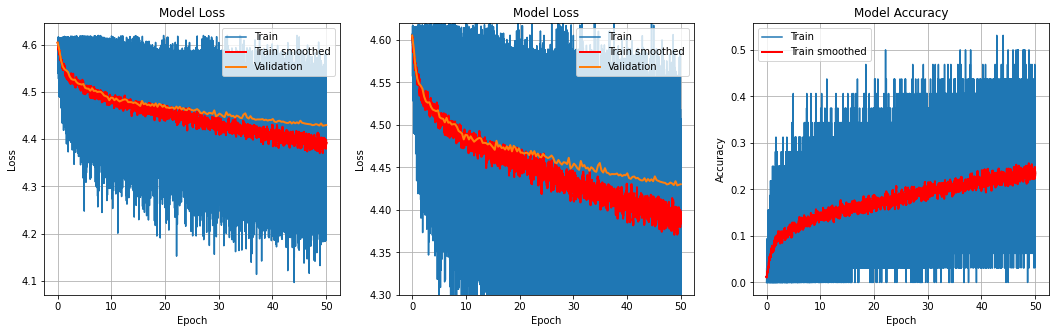

In [30]:
fig, axs = plt.subplots(1, 3)
fig.set_size_inches(18, 5)

axs[0].plot(np.linspace(0, 50, len(CIFAR_train_loss_array)), CIFAR_train_loss_array, label="Train")


smoothed_train_loss = movingaverage(CIFAR_train_loss_array,100)[50:-50]
axs[0].plot(np.linspace(0, 50, len(smoothed_train_loss)), smoothed_train_loss,
                        label="Train smoothed", linewidth=2, color="red")
axs[0].plot(np.linspace(0, 50, len(CIFAR_val_loss_array)), CIFAR_val_loss_array,label = "Validation", linewidth=2) 


axs[0].set_title("Model Loss")
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend(loc="upper right")
axs[0].grid()

axs[2].plot(np.linspace(0, 50, len(CIFAR_mini_batch_accuracy)), CIFAR_mini_batch_accuracy, label="Train")
axs[2].plot(np.linspace(0, 50, len(movingaverage(CIFAR_mini_batch_accuracy,100)[50:-50])),
            movingaverage(CIFAR_mini_batch_accuracy,100)[50:-50],label="Train smoothed",
            linewidth=2, color="red",)
axs[2].set_title("Model Accuracy")
axs[2].set_xlabel('Epoch')
axs[2].set_ylabel('Accuracy')
axs[2].legend()
axs[2].grid()


axs[1].plot(np.linspace(0, 50, len(CIFAR_train_loss_array)), CIFAR_train_loss_array, label="Train")


smoothed_train_loss = movingaverage(CIFAR_train_loss_array,100)[50:-50]
axs[1].plot(np.linspace(0, 50, len(smoothed_train_loss)), smoothed_train_loss,
                        label="Train smoothed", linewidth=2, color="red")
axs[1].plot(np.linspace(0, 50, len(CIFAR_val_loss_array)), CIFAR_val_loss_array,label = "Validation", linewidth=2)
axs[1].set_title("Model Loss")
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].set_ylim(4.3,4.62)

axs[1].legend()
axs[1].grid()

plt.show()

In [28]:
CIFAR_metric_list = np.array(CIFAR_metric_list)
class_avg = CIFAR_metric_list.sum(axis=2)/classes

print("Final test set performance metrics:\n(averaged across {} classes)\n------------------------".format(classes))
metric_labels = ['precision', 'recall', 'f1', 'accuracy']
for i, label in enumerate(metric_labels):
    print("{0}: {1:.4f}".format(label, class_avg[-1,i]))

Final test set performance metrics:
(averaged across 100 classes)
------------------------
precision: 0.1140
recall: 0.1945
f1: 0.1340
accuracy: 0.1945


In [32]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='latin1')
    return dict

cifar_100_labels = unpickle('cifar-100-python\meta')
cifar_100_fined_labels = cifar_100_labels['fine_label_names']

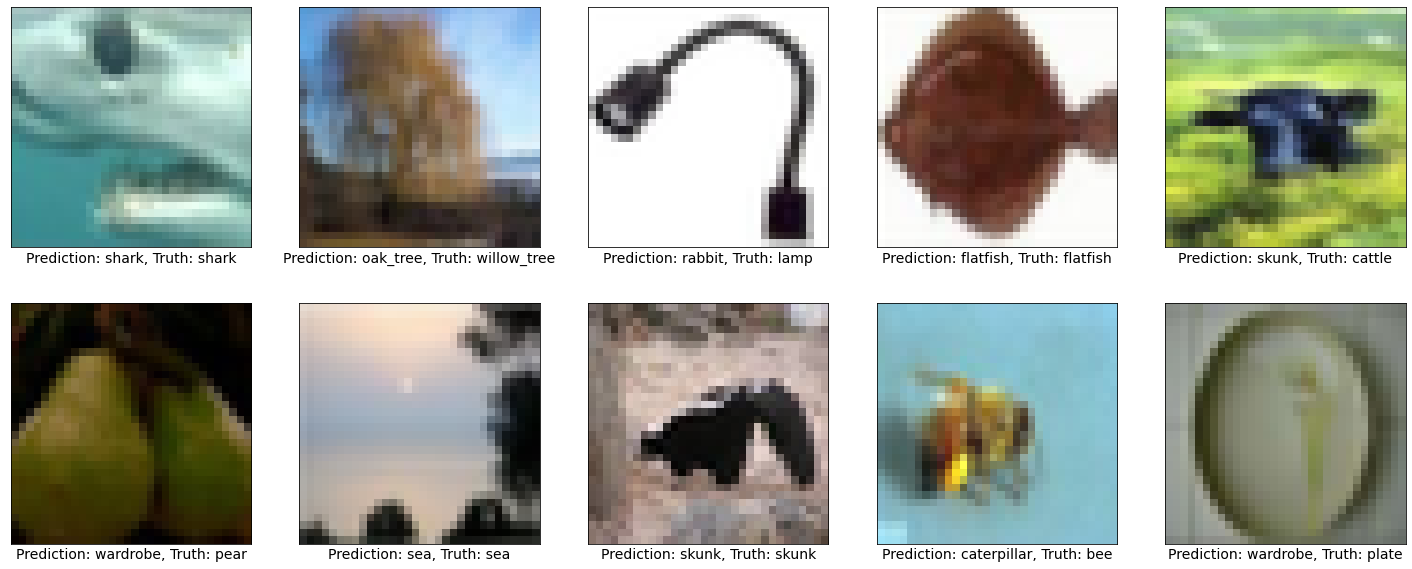

In [36]:
for X, y in testset_CIFAR100:
    X, y = X.to(device), y.to(device)

    fig, axs = plt.subplots(nrows=2, ncols=5)
    fig.set_size_inches(25, 10)

    for i, ax in enumerate(axs.reshape(-1)):        
        
        
        image_data = np.moveaxis(X[i].cpu().numpy(),0,-1)
        ax.imshow(image_data)
        
        output = CIFAR_model(X[i].reshape(-1, 3, 32, 32))
        prediction = torch.argmax(output, dim=1).cpu().numpy()[0]
        turth = y[i].item()
        
        ax.set_xlabel("Prediction: {}, Truth: {}".format(cifar_100_fined_labels[prediction], cifar_100_fined_labels[turth]), fontsize=14)
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        ax.set_xticks([])
        ax.set_yticks([])
        
    fig.show()
    break

### Visualizing Feature Maps

Conv 1 Activation Maps


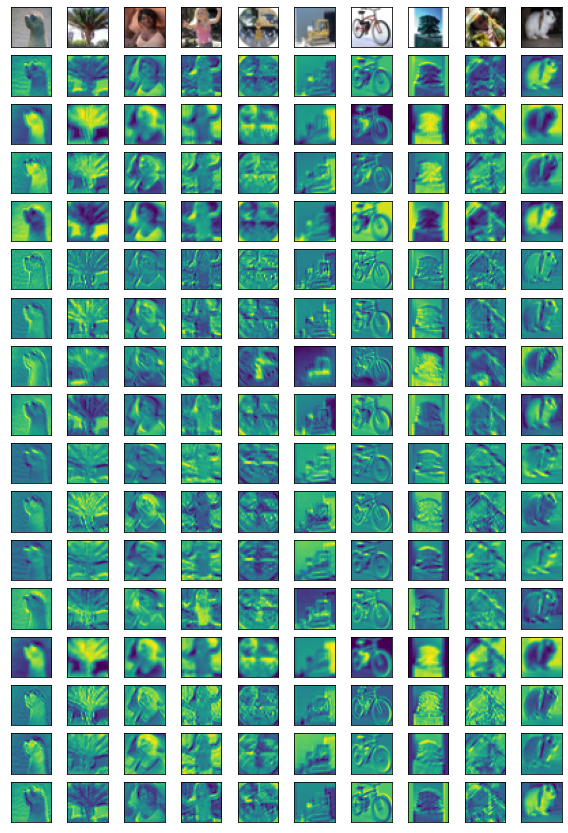

In [166]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

for X, y in testset_CIFAR100:
    X, y = X.to(device), y.to(device)
    
    fig, axarr = plt.subplots(nrows = act.size(0)+1, ncols=10, figsize=(7,7))
    fig.set_size_inches(10, 15)

    for i in range(10):        
        
        CIFAR_model.conv1[0].register_forward_hook(get_activation('conv1'))
        data=X[i].reshape(-1, 3, 32, 32)
        output_test = CIFAR_model(data)

        act = activation['conv1'].squeeze()

        for idx in range(1, act.size(0) +1):
            axarr[idx][i].imshow(act[idx-1].cpu())
            axarr[idx][i].set_yticklabels([])
            axarr[idx][i].set_xticklabels([])
            axarr[idx][i].set_xticks([])
            axarr[idx][i].set_yticks([])
        
        image_data = np.moveaxis(X[i].cpu().numpy(),0,-1)
        axarr[0][i].imshow(image_data)
        axarr[0][i].set_yticklabels([])
        axarr[0][i].set_xticklabels([])
        axarr[0][i].set_xticks([])
        axarr[0][i].set_yticks([])
        
    print("Conv 1 Activation Maps")
    plt.show()
    break

Conv 2 Activation Maps


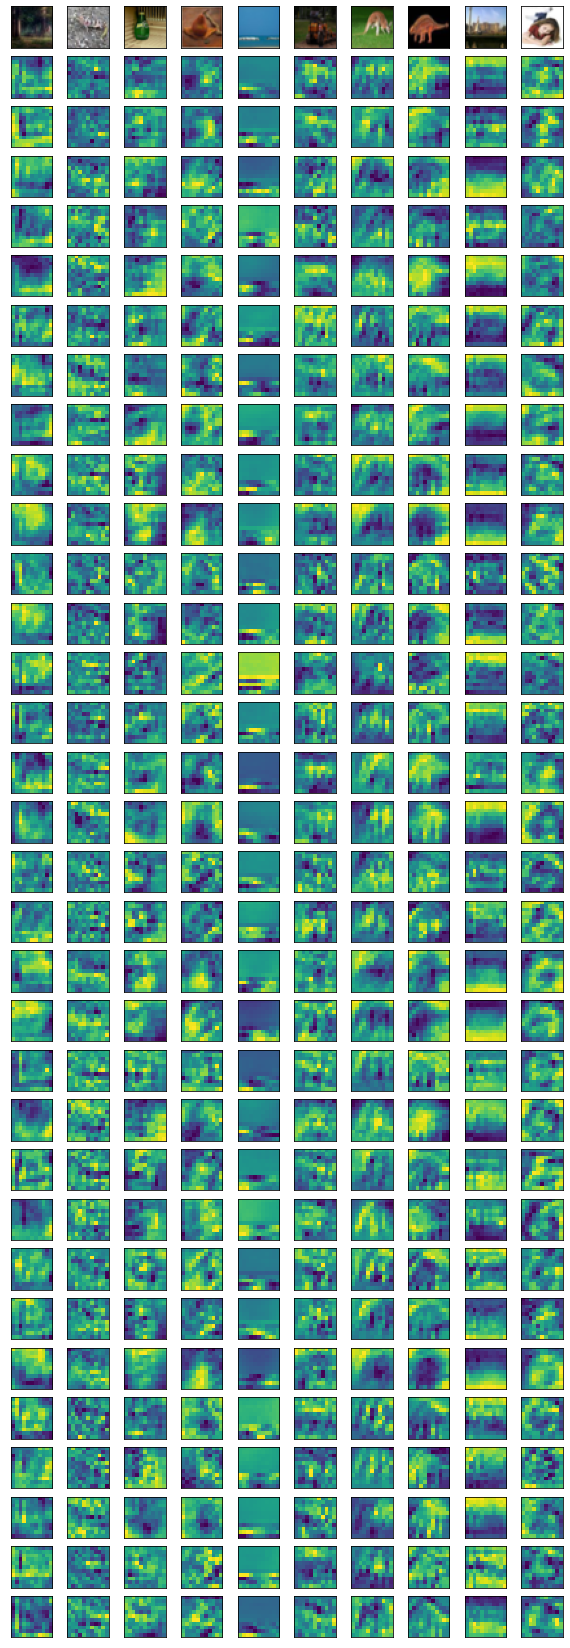

In [174]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

for X, y in testset_CIFAR100:
    X, y = X.to(device), y.to(device)
    
    fig, axarr = plt.subplots(nrows = act.size(0)+1, ncols=10, figsize=(7,7))
    fig.set_size_inches(10, 30)

    for i in range(10):        
        
        CIFAR_model.conv2[0].register_forward_hook(get_activation('conv2'))
        data=X[i].reshape(-1, 3, 32, 32)
        output_test = CIFAR_model(data)

        act = activation['conv2'].squeeze()

        for idx in range(1, act.size(0) +1):
            axarr[idx][i].imshow(act[idx-1].cpu())
            axarr[idx][i].set_yticklabels([])
            axarr[idx][i].set_xticklabels([])
            axarr[idx][i].set_xticks([])
            axarr[idx][i].set_yticks([])
        
        image_data = np.moveaxis(X[i].cpu().numpy(),0,-1)
        axarr[0][i].imshow(image_data)
        axarr[0][i].set_yticklabels([])
        axarr[0][i].set_xticklabels([])
        axarr[0][i].set_xticks([])
        axarr[0][i].set_yticks([])
        
    print("Conv 2 Activation Maps")
    plt.show()
    break

### Visualizing Filters

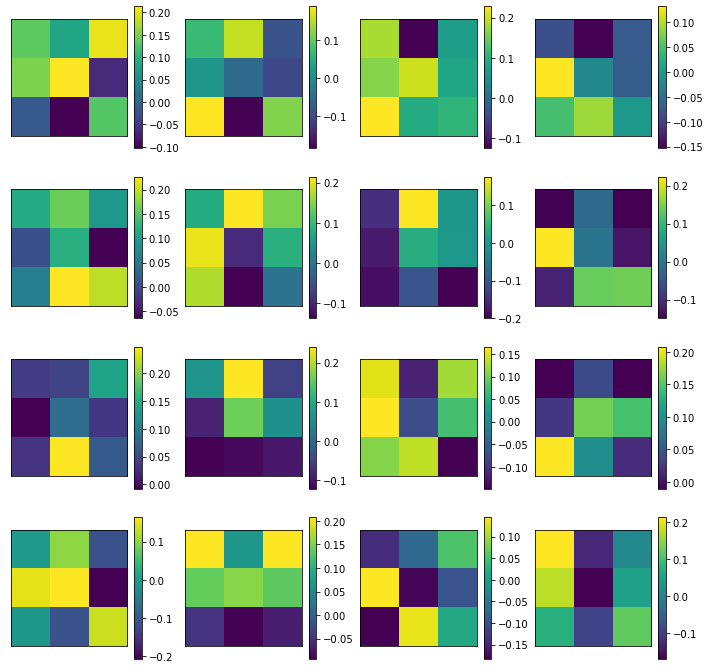

In [39]:
conv1_weights = CIFAR_model.conv1[0].weight.cpu().detach().numpy()

fig, axs = plt.subplots(nrows = 4, ncols=4, figsize=(7,7))
fig.set_size_inches(12, 12)

for filter_id, ax in enumerate(axs.reshape(-1)):

    plot = ax.imshow(conv1_weights[filter_id][0])
    fig.colorbar(plot, ax=ax)
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_xticks([])
    ax.set_yticks([])
    
plt.show()


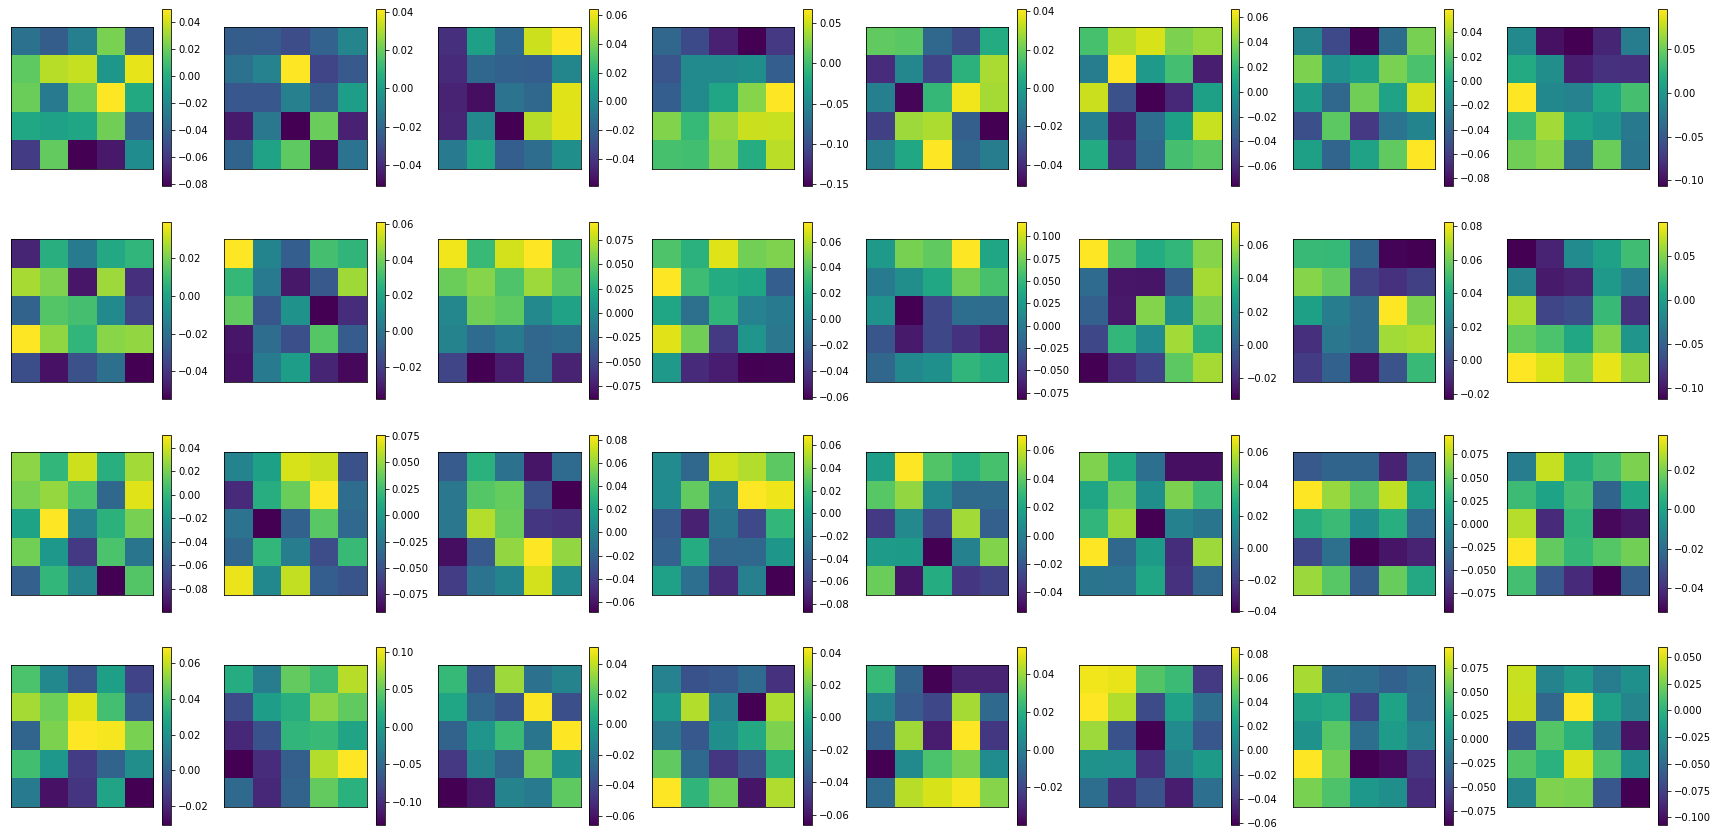

In [42]:
conv2_weights = CIFAR_model.conv2[0].weight.cpu().detach().numpy()

fig, axs = plt.subplots(nrows = 4, ncols=8, figsize=(7,7))
fig.set_size_inches(30, 15)

for filter_id, ax in enumerate(axs.reshape(-1)):

    plot = ax.imshow(conv2_weights[filter_id][0])
    fig.colorbar(plot, ax=ax)
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_xticks([])
    ax.set_yticks([])
    
plt.show()
